# Comparison: True vs Theory vs Empirical vs Model

Compare predictions from:
1. **True** - ground truth function
2. **EK Theory** - using theoretical eigenvalues from mean-field theory
3. **EK Empirical** - using empirical eigenvalues from training data
4. **Model** - neural network predictions (averaged over seeds)

All predictions use ridge-weighted eigenvalues: **weight = λ / (λ + κ/P)**

## Structure
- **Test Data**: Out-of-sample generalization
- **Training Data**: In-sample fit
- **Modular Plotting**: Reusable functions for consistency


In [1]:
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys
sys.path.append('/home/akiva/FCNX-Ensembling/lib')
from FCN3Network import FCN3NetworkActivationGeneric

# Set random seed
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Base directory
base_dir = Path("/home/akiva/FCNX-Ensembling/milestones/activation_generic_erf_mf_scaling_convergence/p_scan_erf_kappa0.07/d150_P800_N1600_chi50_kappa0.07")
seed_dirs = sorted([d for d in base_dir.iterdir() if d.is_dir() and d.name.startswith('seed')])

# Load config
with open(seed_dirs[0] / "config.json") as f:
    config = json.load(f)
d, P, N, chi, kappa = config['d'], config['P'], config['N'], config['chi'], config.get('kappa', 0.07)
print(f"Config: d={d}, P={P}, N={N}, chi={chi}, kappa={kappa}")
print(f"Found {len(seed_dirs)} seeds")

Config: d=150, P=800, N=1600, chi=50, kappa=0.07
Found 5 seeds


In [2]:
# Load theoretical eigenvalues
with open(base_dir / "theory_cache.json") as f:
    theory = json.load(f)
lH1T_theory = theory['lH1T']
lH3T_theory = theory['lH3T']
kappa_eff_theory = theory.get('kappa_eff', kappa)

print(f"Theoretical eigenvalues:")
print(f"  lH1T: {lH1T_theory:.6e}")
print(f"  lH3T: {lH3T_theory:.6e}")
print(f"  kappa_eff: {kappa_eff_theory:.6e}")

# Load empirical eigenvalues (averaged over seeds)
all_h3_data = [json.load(open(sd / "h3_projections_fcn3.json")) for sd in seed_dirs]
lH1T_empirical = np.mean([d['h1']['target']['second_moment'] for d in all_h3_data])
lH3T_empirical = np.mean([d['h3']['target']['second_moment'] for d in all_h3_data])

print(f"\nEmpirical eigenvalues (avg over {len(seed_dirs)} seeds):")
print(f"  lH1T: {lH1T_empirical:.6e}")
print(f"  lH3T: {lH3T_empirical:.6e}")

print(f"\nRatio (Empirical/Theory):")
print(f"  lH1T: {lH1T_empirical/lH1T_theory:.3f}")
print(f"  lH3T: {lH3T_empirical/lH3T_theory:.3f}")

Theoretical eigenvalues:
  lH1T: 2.374060e-02
  lH3T: 3.359900e-06
  kappa_eff: 1.292905e-01

Empirical eigenvalues (avg over 5 seeds):
  lH1T: 2.031751e-02
  lH3T: 3.687400e-06

Ratio (Empirical/Theory):
  lH1T: 0.856
  lH3T: 1.097


In [3]:
# Load models from all seeds
models = []
for seed_dir in seed_dirs:
    model = FCN3NetworkActivationGeneric(d=d, n1=N, n2=N, P=P, ens=config['ens']).to(device)
    model.load_state_dict(torch.load(seed_dir / "model.pt", map_location=device))
    model.eval()
    models.append(model)
print(f"Loaded {len(models)} models")

Loaded 5 models


In [4]:
# Generate test set
n_test = P
X_test = torch.randn(n_test, d, dtype=torch.float32, device=device)
X_test = X_test 

# Hermite components
x0 = X_test[:, 0]
he1 = x0  # Linear
he3 = x0**3 - 3*x0  # Cubic

# True target: He1 + 0.03 * He3
true_coef_H1 = 1.0
true_coef_H3 = 0.03
y_true = true_coef_H1 * he1 + true_coef_H3 * he3
y_true_linear = true_coef_H1 * he1
y_true_cubic = true_coef_H3 * he3

print(f"Test set: {X_test.shape}, y_true: {y_true.shape}")

Test set: torch.Size([800, 150]), y_true: torch.Size([800])


In [ ]:
# Load theoretical eigenvalues
with open(base_dir / "theory_cache.json") as f:
    theory = json.load(f)
lH1T_theory = theory['lH1T']
lH3T_theory = theory['lH3T']
kappa_eff_theory = theory.get('kappa_eff', kappa)

print(f"Theoretical eigenvalues:")
print(f"  lH1T: {lH1T_theory:.6e}")
print(f"  lH3T: {lH3T_theory:.6e}")
print(f"  kappa_eff: {kappa_eff_theory:.6e}")

# Load empirical eigenvalues (averaged over seeds)
all_h3_data = [json.load(open(sd / "h3_projections_fcn3.json")) for sd in seed_dirs]
lH1T_empirical = np.mean([d['h1']['target']['second_moment'] for d in all_h3_data])
lH3T_empirical = np.mean([d['h3']['target']['second_moment'] for d in all_h3_data])

print(f"\nEmpirical eigenvalues (avg over {len(seed_dirs)} seeds):")
print(f"  lH1T: {lH1T_empirical:.6e}")
print(f"  lH3T: {lH3T_empirical:.6e}")

print(f"\nRatio (Empirical/Theory):")
print(f"  lH1T: {lH1T_empirical/lH1T_theory:.3f}")
print(f"  lH3T: {lH3T_empirical/lH3T_theory:.3f}")

# Compute ridge weights: lambda / (lambda + kappa_eff / P)
effective_ridge = kappa / P

# Theory-based EK predictor
weight_H1T_theory = lH1T_theory / (lH1T_theory + effective_ridge)
weight_H3T_theory = lH3T_theory / (lH3T_theory + effective_ridge)
y_ek_theory_linear = weight_H1T_theory * true_coef_H1 * he1
y_ek_theory_cubic = weight_H3T_theory * true_coef_H3 * he3
y_ek_theory = y_ek_theory_linear + y_ek_theory_cubic

# Empirical-based EK predictor
weight_H1T_empirical = lH1T_empirical / (lH1T_empirical + effective_ridge)
weight_H3T_empirical = lH3T_empirical / (lH3T_empirical + effective_ridge)
y_ek_empirical_linear = weight_H1T_empirical * true_coef_H1 * he1
y_ek_empirical_cubic = weight_H3T_empirical * true_coef_H3 * he3
y_ek_empirical = y_ek_empirical_linear + y_ek_empirical_cubic

# Model predictions (averaged over seeds)
with torch.no_grad():
    all_preds = [model(X_test).mean(axis=1).squeeze() for model in models]
y_model = torch.stack(all_preds).mean(dim=0)

print(f"Ridge weights (Theory):    H1={weight_H1T_theory:.4f}, H3={weight_H3T_theory:.4f}")
print(f"Ridge weights (Empirical): H1={weight_H1T_empirical:.4f}, H3={weight_H3T_empirical:.4f}")

Ridge weights (Theory):    H1=0.9963, H3=0.0370
Ridge weights (Empirical): H1=0.9957, H3=0.0404


In [6]:
# Compute MSEs
mse_ek_theory = ((y_ek_theory - y_true)**2).mean().item()
mse_ek_empirical = ((y_ek_empirical - y_true)**2).mean().item()
mse_model = ((y_model - y_true)**2).mean().item()

print(f"\nMSE Comparison:")
print(f"  EK Theory:    {mse_ek_theory:.6e}")
print(f"  EK Empirical: {mse_ek_empirical:.6e}")
print(f"  Model:        {mse_model:.6e}")
print(f"\nRatios:")
print(f"  EK Theory / Model:    {mse_ek_theory / mse_model:.3f}")
print(f"  EK Empirical / Model: {mse_ek_empirical / mse_model:.3f}")


MSE Comparison:
  EK Theory:    3.429732e-03
  EK Empirical: 3.403570e-03
  Model:        7.083060e-01

Ratios:
  EK Theory / Model:    0.005
  EK Empirical / Model: 0.005


In [10]:
# Define plotting functions
def plot_scatter_comparison(x0, y_true, y_model, y_theory, y_empirical,
                            y_true_linear, y_theory_linear, y_empirical_linear,
                            y_true_cubic, y_theory_cubic, y_empirical_cubic,
                            weight_H1T_theory, weight_H3T_theory,
                            weight_H1T_empirical, weight_H3T_empirical,
                            title_prefix=""):
    """Create 2x2 scatter plot comparing predictions vs x[:,0]"""
    x0_cpu = x0.cpu()
    sort_idx = torch.argsort(x0_cpu)
    x0_sorted = x0_cpu[sort_idx]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Subplot 1: Overall predictions
    axes[0, 0].scatter(x0_sorted, y_true[sort_idx].cpu(), s=4, alpha=0.3, color='black', label='True', zorder=1)
    axes[0, 0].scatter(x0_sorted, y_model[sort_idx].cpu(), s=4, alpha=0.3, color='blue', label='Model', zorder=2)
    axes[0, 0].scatter(x0_sorted, y_theory[sort_idx].cpu(), s=4, alpha=0.3, color='red', label='EK Theory', zorder=3)
    axes[0, 0].scatter(x0_sorted, y_empirical[sort_idx].cpu(), s=4, alpha=0.3, color='green', label='EK Empirical', zorder=4)
    axes[0, 0].set_xlabel('x[:,0]', fontsize=12)
    axes[0, 0].set_ylabel('Prediction', fontsize=12)
    axes[0, 0].set_title(f'{title_prefix}Overall Predictions vs x[:,0]', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: Linear component
    axes[0, 1].scatter(x0_sorted, y_true_linear[sort_idx].cpu(), s=4, alpha=0.3, color='black', label='True', zorder=1)
    axes[0, 1].scatter(x0_sorted, y_theory_linear[sort_idx].cpu(), s=4, alpha=0.3, color='red', label=f'Theory (w={weight_H1T_theory:.3f})', zorder=2)
    axes[0, 1].scatter(x0_sorted, y_empirical_linear[sort_idx].cpu(), s=4, alpha=0.3, color='green', label=f'Empirical (w={weight_H1T_empirical:.3f})', zorder=3)
    axes[0, 1].set_xlabel('x[:,0]', fontsize=12)
    axes[0, 1].set_ylabel('Linear Component', fontsize=12)
    axes[0, 1].set_title(f'{title_prefix}Linear (He1) Component', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Subplot 3: Cubic component
    axes[1, 0].scatter(x0_sorted, y_true_cubic[sort_idx].cpu(), s=4, alpha=0.3, color='black', label='True', zorder=1)
    axes[1, 0].scatter(x0_sorted, y_theory_cubic[sort_idx].cpu(), s=4, alpha=0.3, color='red', label=f'Theory (w={weight_H3T_theory:.3f})', zorder=2)
    axes[1, 0].scatter(x0_sorted, y_empirical_cubic[sort_idx].cpu(), s=4, alpha=0.3, color='green', label=f'Empirical (w={weight_H3T_empirical:.3f})', zorder=3)
    axes[1, 0].set_xlabel('x[:,0]', fontsize=12)
    axes[1, 0].set_ylabel('Cubic Component', fontsize=12)
    axes[1, 0].set_title(f'{title_prefix}Cubic (He3) Component', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Subplot 4: Errors
    axes[1, 1].scatter(x0_sorted, (y_model[sort_idx] - y_true[sort_idx]).cpu(), s=4, alpha=0.3, color='blue', label='Model Error')
    axes[1, 1].scatter(x0_sorted, (y_theory[sort_idx] - y_true[sort_idx]).cpu(), s=4, alpha=0.3, color='red', label='EK Theory Error')
    axes[1, 1].scatter(x0_sorted, (y_empirical[sort_idx] - y_true[sort_idx]).cpu(), s=4, alpha=0.3, color='green', label='EK Empirical Error')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axes[1, 1].set_xlabel('x[:,0]', fontsize=12)
    axes[1, 1].set_ylabel('Prediction Error', fontsize=12)
    axes[1, 1].set_title(f'{title_prefix}Prediction Errors vs x[:,0]', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def bin_data(x, y, bins):
    """Compute binned statistics"""
    bin_means, bin_stds = [], []
    for i in range(len(bins) - 1):
        mask = (x >= bins[i]) & (x < bins[i+1])
        if mask.sum() > 0:
            bin_means.append(y[mask].mean())
            bin_stds.append(y[mask].std())
        else:
            bin_means.append(np.nan)
            bin_stds.append(np.nan)
    return np.array(bin_means), np.array(bin_stds)

def plot_binned_comparison(x0, y_true, y_model, y_theory, y_empirical,
                           y_true_linear, y_theory_linear, y_empirical_linear,
                           y_true_cubic, y_theory_cubic, y_empirical_cubic,
                           weight_H1T_theory, weight_H3T_theory,
                           weight_H1T_empirical, weight_H3T_empirical,
                           n_bins=50, title_prefix=""):
    """Create binned comparison plots"""
    x0_cpu = x0.cpu()
    bin_edges = np.linspace(x0_cpu.min(), x0_cpu.max(), n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Compute binned statistics
    y_true_binned, _ = bin_data(x0_cpu, y_true.cpu(), bin_edges)
    y_model_binned, _ = bin_data(x0_cpu, y_model.cpu(), bin_edges)
    y_theory_binned, _ = bin_data(x0_cpu, y_theory.cpu(), bin_edges)
    y_empirical_binned, _ = bin_data(x0_cpu, y_empirical.cpu(), bin_edges)
    y_linear_true_binned, _ = bin_data(x0_cpu, y_true_linear.cpu(), bin_edges)
    y_linear_theory_binned, _ = bin_data(x0_cpu, y_theory_linear.cpu(), bin_edges)
    y_linear_empirical_binned, _ = bin_data(x0_cpu, y_empirical_linear.cpu(), bin_edges)
    y_cubic_true_binned, _ = bin_data(x0_cpu, y_true_cubic.cpu(), bin_edges)
    y_cubic_theory_binned, _ = bin_data(x0_cpu, y_theory_cubic.cpu(), bin_edges)
    y_cubic_empirical_binned, _ = bin_data(x0_cpu, y_empirical_cubic.cpu(), bin_edges)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Overall
    axes[0].plot(bin_centers, y_true_binned, 'k-', linewidth=3, label='True', marker='o', markersize=5)
    axes[0].plot(bin_centers, y_model_binned, 'b-', linewidth=2, label='Model', marker='s', markersize=3, alpha=0.7)
    axes[0].plot(bin_centers, y_theory_binned, 'r--', linewidth=2, label='EK Theory', marker='^', markersize=3)
    axes[0].plot(bin_centers, y_empirical_binned, 'g--', linewidth=2, label='EK Empirical', marker='v', markersize=3)
    axes[0].set_xlabel('x[:,0]', fontsize=12)
    axes[0].set_ylabel('Output', fontsize=12)
    axes[0].set_title(f'{title_prefix}Overall: Binned Predictions', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Linear
    axes[1].plot(bin_centers, y_linear_true_binned, 'k-', linewidth=3, label='True', marker='o', markersize=5)
    axes[1].plot(bin_centers, y_linear_theory_binned, 'r--', linewidth=2, label=f'Theory (w={weight_H1T_theory:.3f})', marker='^', markersize=3)
    axes[1].plot(bin_centers, y_linear_empirical_binned, 'g--', linewidth=2, label=f'Empirical (w={weight_H1T_empirical:.3f})', marker='v', markersize=3)
    axes[1].set_xlabel('x[:,0]', fontsize=12)
    axes[1].set_ylabel('Linear Component', fontsize=12)
    axes[1].set_title(f'{title_prefix}Linear (He1): y = x₀', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Cubic
    axes[2].plot(bin_centers, y_cubic_true_binned, 'k-', linewidth=3, label='True', marker='o', markersize=5)
    axes[2].plot(bin_centers, y_cubic_theory_binned, 'r--', linewidth=2, label=f'Theory (w={weight_H3T_theory:.3f})', marker='^', markersize=3)
    axes[2].plot(bin_centers, y_cubic_empirical_binned, 'g--', linewidth=2, label=f'Empirical (w={weight_H3T_empirical:.3f})', marker='v', markersize=3)
    axes[2].set_xlabel('x[:,0]', fontsize=12)
    axes[2].set_ylabel('Cubic Component', fontsize=12)
    axes[2].set_title(f'{title_prefix}Cubic (He3): y = x₀³ - 3x₀', fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("Plotting functions defined")


Plotting functions defined


TEST DATA EVALUATION


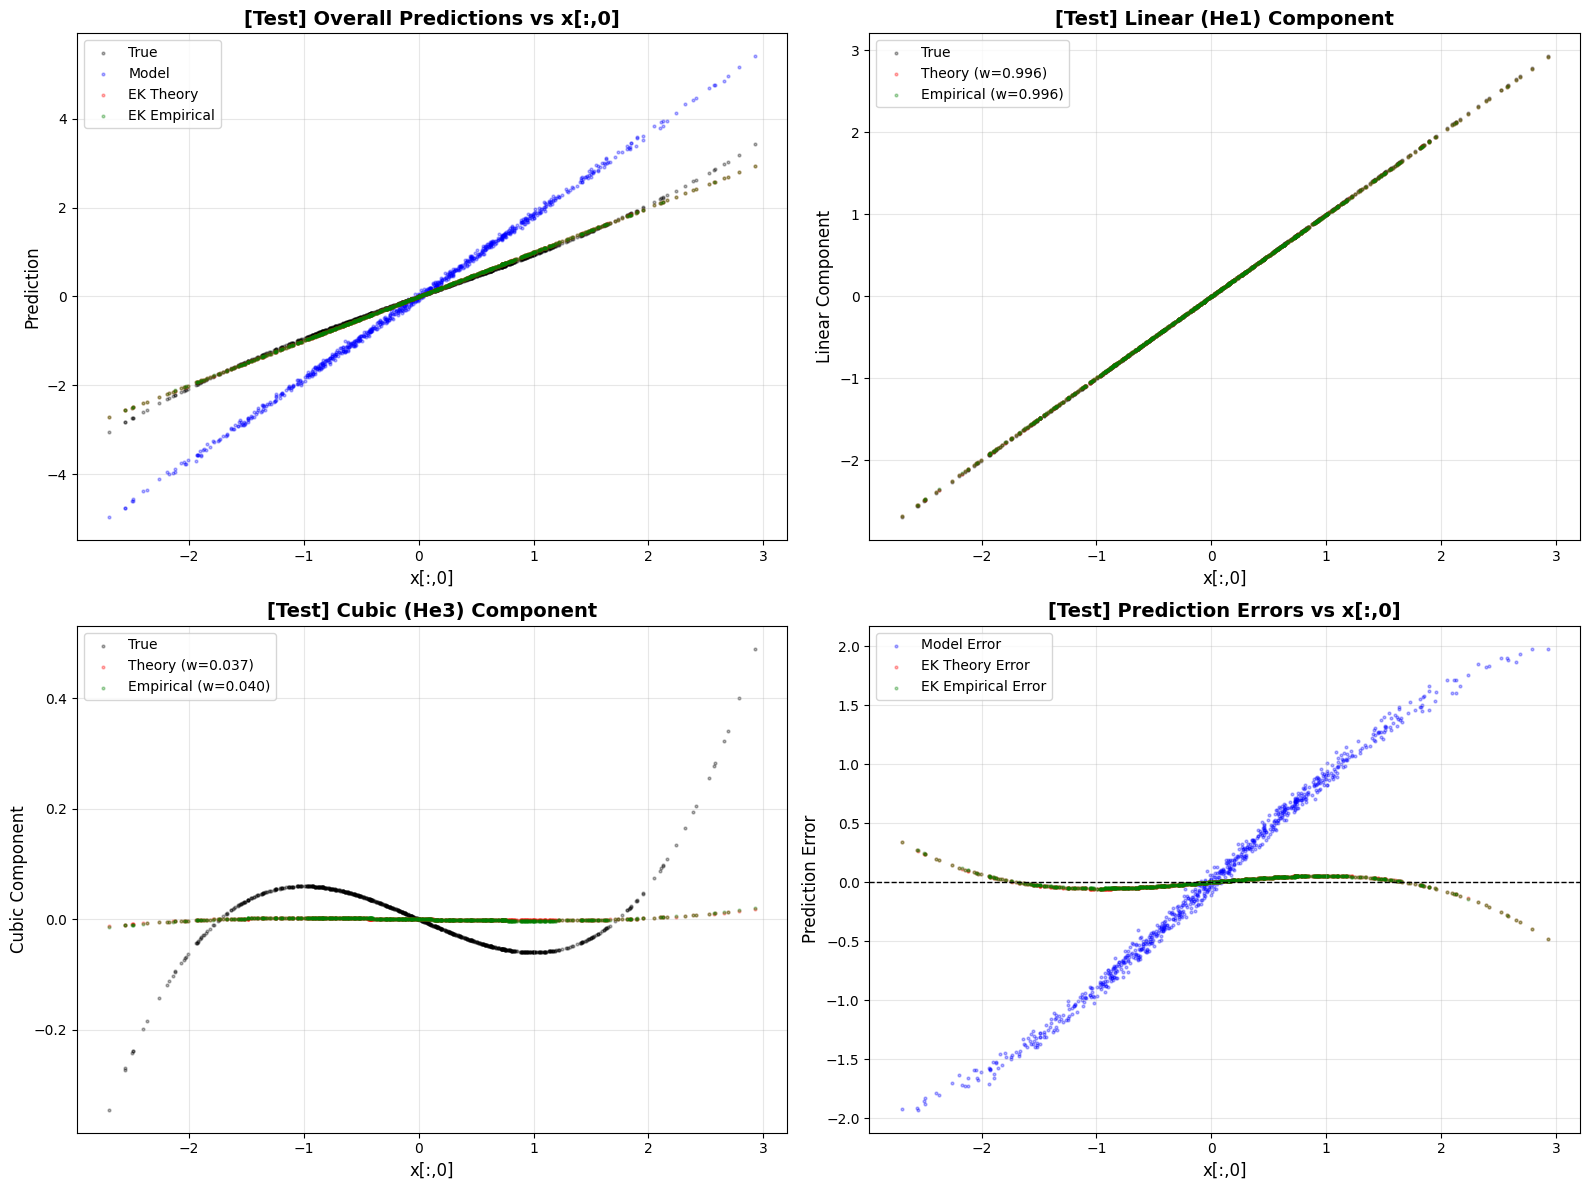

In [11]:
# Test Data: Scatter plots
print("="*80)
print("TEST DATA EVALUATION")
print("="*80)
plot_scatter_comparison(
    x0, y_true, y_model, y_ek_theory, y_ek_empirical,
    y_true_linear, y_ek_theory_linear, y_ek_empirical_linear,
    y_true_cubic, y_ek_theory_cubic, y_ek_empirical_cubic,
    weight_H1T_theory, weight_H3T_theory,
    weight_H1T_empirical, weight_H3T_empirical,
    title_prefix="[Test] "
)


In [21]:
# Summary table - Test Data Only
print("\n" + "="*80)
print("SUMMARY: Ridge-Weighted Predictions (TEST DATA)")
print("="*80)
print(f"{'Method':<20} {'MSE':>15} {'Linear Weight':>15} {'Cubic Weight':>15}")
print("-"*80)
print(f"{'EK Theory':<20} {mse_ek_theory:>15.6e} {weight_H1T_theory:>15.4f} {weight_H3T_theory:>15.4f}")
print(f"{'EK Empirical':<20} {mse_ek_empirical:>15.6e} {weight_H1T_empirical:>15.4f} {weight_H3T_empirical:>15.4f}")
print(f"{'Model (avg seeds)':<20} {mse_model:>15.6e} {'N/A':>15} {'N/A':>15}")
print("="*80)

print(f"\nEigenvalues:")
print(f"{'':20} {'Linear (H1T)':>20} {'Cubic (H3T)':>20}")
print(f"{'Theory':<20} {lH1T_theory:>20.6e} {lH3T_theory:>20.6e}")
print(f"{'Empirical':<20} {lH1T_empirical:>20.6e} {lH3T_empirical:>20.6e}")
print(f"{'Ratio (Emp/Theory)':<20} {lH1T_empirical/lH1T_theory:>20.3f} {lH3T_empirical/lH3T_theory:>20.3f}")



SUMMARY: Ridge-Weighted Predictions (TEST DATA)
Method                           MSE   Linear Weight    Cubic Weight
--------------------------------------------------------------------------------
EK Theory               5.549674e-03          0.9963          0.0370
EK Empirical            5.519519e-03          0.9957          0.0404
Model (avg seeds)       7.360657e-01             N/A             N/A

Eigenvalues:
                             Linear (H1T)          Cubic (H3T)
Theory                       2.374060e-02         3.359900e-06
Empirical                    2.031751e-02         3.687400e-06
Ratio (Emp/Theory)                  0.856                1.097


/tmp/ipykernel_326911/3935770236.py:67: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  bin_stds.append(y[mask].std())


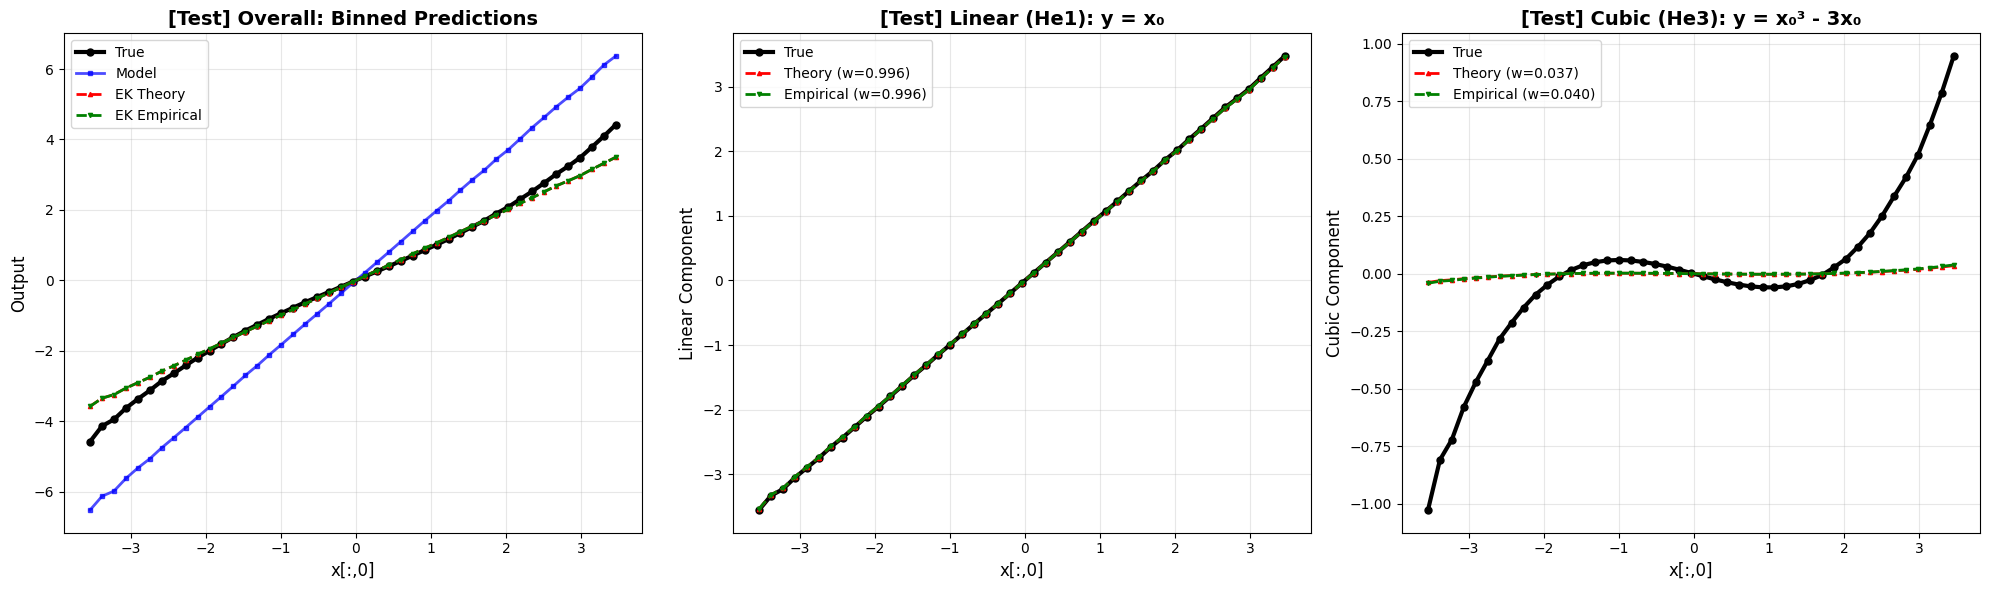

In [22]:
# Test Data: Binned plots
plot_binned_comparison(
    x0, y_true, y_model, y_ek_theory, y_ek_empirical,
    y_true_linear, y_ek_theory_linear, y_ek_empirical_linear,
    y_true_cubic, y_ek_theory_cubic, y_ek_empirical_cubic,
    weight_H1T_theory, weight_H3T_theory,
    weight_H1T_empirical, weight_H3T_empirical,
    n_bins=50, title_prefix="[Test] "
)


## Training Data Evaluation

Evaluate models on their training data to compare in-sample vs out-of-sample performance.

**Important**: Each model is evaluated on its own seed's training data. The seed number is extracted from the directory name (e.g., "seed1" → seed 1) and used to regenerate the exact training data that model was trained on via `torch.manual_seed(seed_num)`.

**Visualization**: Training data from all seeds are concatenated together for visualization, showing the full picture across all models. Each model's predictions on its own seed's data are also concatenated.

In [12]:
# Generate training data for each seed by extracting seed from directory name
import re

def extract_seed_number(seed_dir):
    """Extract seed number from directory name like 'seed1', 'seed2', etc."""
    match = re.search(r'seed(\d+)', seed_dir.name)
    if match:
        return int(match.group(1))
    return 0  # Default fallback

# Generate training data for each seed and collect predictions
all_train_data = []
all_train_preds = []

print("Generating training data for each seed and evaluating models...")
for i, (seed_dir, model) in enumerate(zip(seed_dirs, models)):
    print(seed_dir.name)
    # Extract seed number from directory name
    seed_num = extract_seed_number(seed_dir)
    print(seed_num)
    # Set random seed on device
    torch.manual_seed(seed_num)
    # torch.cuda.manual_seed_all(seed_num) if torch.cuda.is_available() else None
    
    # Generate training data with this seed
    X_train_seed = torch.randn(P, d, device='cuda:0')
    X_train_seed = X_train_seed 
    
    # Compute true targets
    x0_train_seed = X_train_seed[:, 0]
    he1_train_seed = x0_train_seed
    he3_train_seed = x0_train_seed**3 - 3*x0_train_seed
    Y_train_seed = true_coef_H1 * he1_train_seed + true_coef_H3 * he3_train_seed
    
    # Subsample for efficiency
    n_train_vis = P
    indices = torch.randperm(len(X_train_seed), device=device)[:n_train_vis]
    X_train_vis_seed = X_train_seed
    Y_train_vis_seed = Y_train_seed
    
    # Evaluate this model on its training data
    with torch.no_grad():
        y_pred_seed = model(X_train_vis_seed)[:,0].squeeze()
    
    all_train_data.append({
        'X': X_train_vis_seed,
        'Y': Y_train_vis_seed,
        'seed': seed_num
    })
    all_train_preds.append(y_pred_seed)
    
    train_mse_seed = ((y_pred_seed - Y_train_vis_seed)**2).mean().item()
    print(f"  Seed {seed_num} ({seed_dir.name}): Train MSE = {train_mse_seed:.6e}, samples = {n_train_vis}")

print(f"\nGenerated {len(all_train_data)} training datasets, one per seed")
print(f"Total samples when concatenated: {sum(len(d['X']) for d in all_train_data)}")
print(f"Predictions stored for each model on its own seed's data")


Generating training data for each seed and evaluating models...
seed1
1
  Seed 1 (seed1): Train MSE = 7.611046e-01, samples = 800
seed2
2
  Seed 2 (seed2): Train MSE = 7.963681e-01, samples = 800
seed3
3
  Seed 3 (seed3): Train MSE = 6.927341e-01, samples = 800
seed4
4
  Seed 4 (seed4): Train MSE = 7.250243e-01, samples = 800
seed5
5
  Seed 5 (seed5): Train MSE = 7.525131e-01, samples = 800

Generated 5 training datasets, one per seed
Total samples when concatenated: 4000
Predictions stored for each model on its own seed's data


In [13]:
# Compute predictions on training data (concatenating all seeds for visualization)
# Concatenate all training data from all seeds
X_train_concat = torch.cat([train_data['X'] for train_data in all_train_data], dim=0)
Y_train_concat = torch.cat([train_data['Y'] for train_data in all_train_data], dim=0)

# Concatenate all model predictions (each model evaluated on its own seed's data)
y_model_train_concat = torch.cat(all_train_preds, dim=0)

# Compute Hermite components on concatenated data
x0_train = X_train_concat[:, 0]
he1_train = x0_train
he3_train = x0_train**3 - 3*x0_train

# True targets (should match Y_train_concat)
y_true_train = Y_train_concat
y_true_linear_train = true_coef_H1 * he1_train
y_true_cubic_train = true_coef_H3 * he3_train

# Theory-based EK predictor
y_ek_theory_linear_train = weight_H1T_theory * true_coef_H1 * he1_train
y_ek_theory_cubic_train = weight_H3T_theory * true_coef_H3 * he3_train
y_ek_theory_train = y_ek_theory_linear_train + y_ek_theory_cubic_train

# Empirical-based EK predictor
y_ek_empirical_linear_train = weight_H1T_empirical * true_coef_H1 * he1_train
y_ek_empirical_cubic_train = weight_H3T_empirical * true_coef_H3 * he3_train
y_ek_empirical_train = y_ek_empirical_linear_train + y_ek_empirical_cubic_train

# Model predictions - use concatenated predictions from all seeds
y_model_train = y_model_train_concat

# Compute training MSEs on concatenated visualization data
mse_ek_theory_train = ((y_ek_theory_train - y_true_train)**2).mean().item()
mse_ek_empirical_train = ((y_ek_empirical_train - y_true_train)**2).mean().item()
mse_model_train = ((y_model_train - y_true_train)**2).mean().item()

# Also compute average MSE across all seeds (each model on its own training data)
all_model_train_mses = []
for train_data, y_pred_seed in zip(all_train_data, all_train_preds):
    mse_seed = ((y_pred_seed - train_data['Y'])**2).mean().item()
    all_model_train_mses.append(mse_seed)
mse_model_train_avg = np.mean(all_model_train_mses)

print("="*80)
print("TRAINING DATA EVALUATION")
print("="*80)
print(f"\nTraining MSE Comparison (concatenated data from {len(all_train_data)} seeds, {len(X_train_concat)} samples):")
print(f"  EK Theory:    {mse_ek_theory_train:.6e}")
print(f"  EK Empirical: {mse_ek_empirical_train:.6e}")
print(f"  Model:        {mse_model_train:.6e}")

print(f"\nAverage Model Train MSE across all seeds (each on own data):")
print(f"  Mean: {mse_model_train_avg:.6e}")
print(f"  Std:  {np.std(all_model_train_mses):.6e}")

print(f"\nRatios (concatenated data):")
print(f"  EK Theory / Model:    {mse_ek_theory_train / mse_model_train:.3f}")
print(f"  EK Empirical / Model: {mse_ek_empirical_train / mse_model_train:.3f}")

print(f"\nTest vs Train MSE Comparison:")
print(f"  Model Test MSE:  {mse_model:.6e}")
print(f"  Model Train MSE (concatenated): {mse_model_train:.6e}")
print(f"  Model Train MSE (avg all seeds): {mse_model_train_avg:.6e}")
print(f"  Ratio (Test/Train concat): {mse_model / mse_model_train:.3f}")
print(f"  Ratio (Test/Train avg):    {mse_model / mse_model_train_avg:.3f}")


TRAINING DATA EVALUATION

Training MSE Comparison (concatenated data from 5 seeds, 4000 samples):
  EK Theory:    4.686637e-03
  EK Empirical: 4.657636e-03
  Model:        7.455489e-01

Average Model Train MSE across all seeds (each on own data):
  Mean: 7.455488e-01
  Std:  3.488189e-02

Ratios (concatenated data):
  EK Theory / Model:    0.006
  EK Empirical / Model: 0.006

Test vs Train MSE Comparison:
  Model Test MSE:  7.083060e-01
  Model Train MSE (concatenated): 7.455489e-01
  Model Train MSE (avg all seeds): 7.455488e-01
  Ratio (Test/Train concat): 0.950
  Ratio (Test/Train avg):    0.950


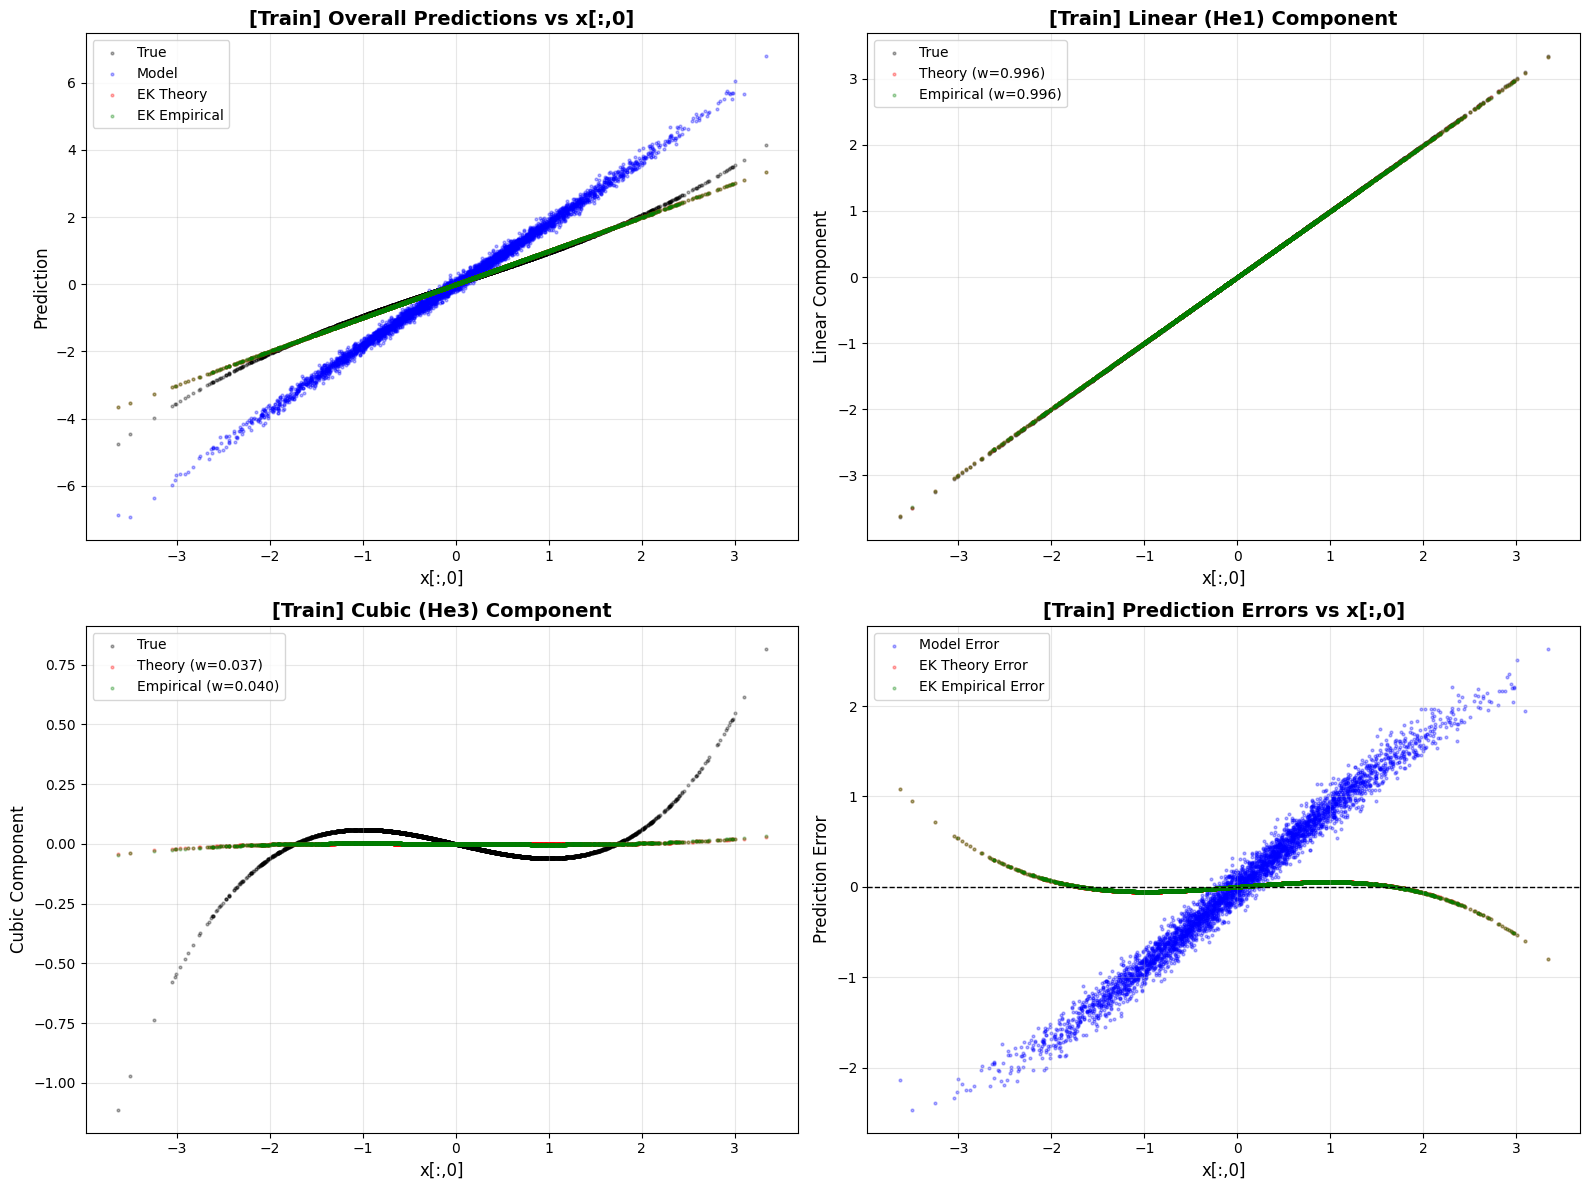

In [14]:
# Training Data: Scatter plots
plot_scatter_comparison(
    x0_train, y_true_train, y_model_train, y_ek_theory_train, y_ek_empirical_train,
    y_true_linear_train, y_ek_theory_linear_train, y_ek_empirical_linear_train,
    y_true_cubic_train, y_ek_theory_cubic_train, y_ek_empirical_cubic_train,
    weight_H1T_theory, weight_H3T_theory,
    weight_H1T_empirical, weight_H3T_empirical,
    title_prefix="[Train] "
)


/tmp/ipykernel_326911/3935770236.py:67: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  bin_stds.append(y[mask].std())


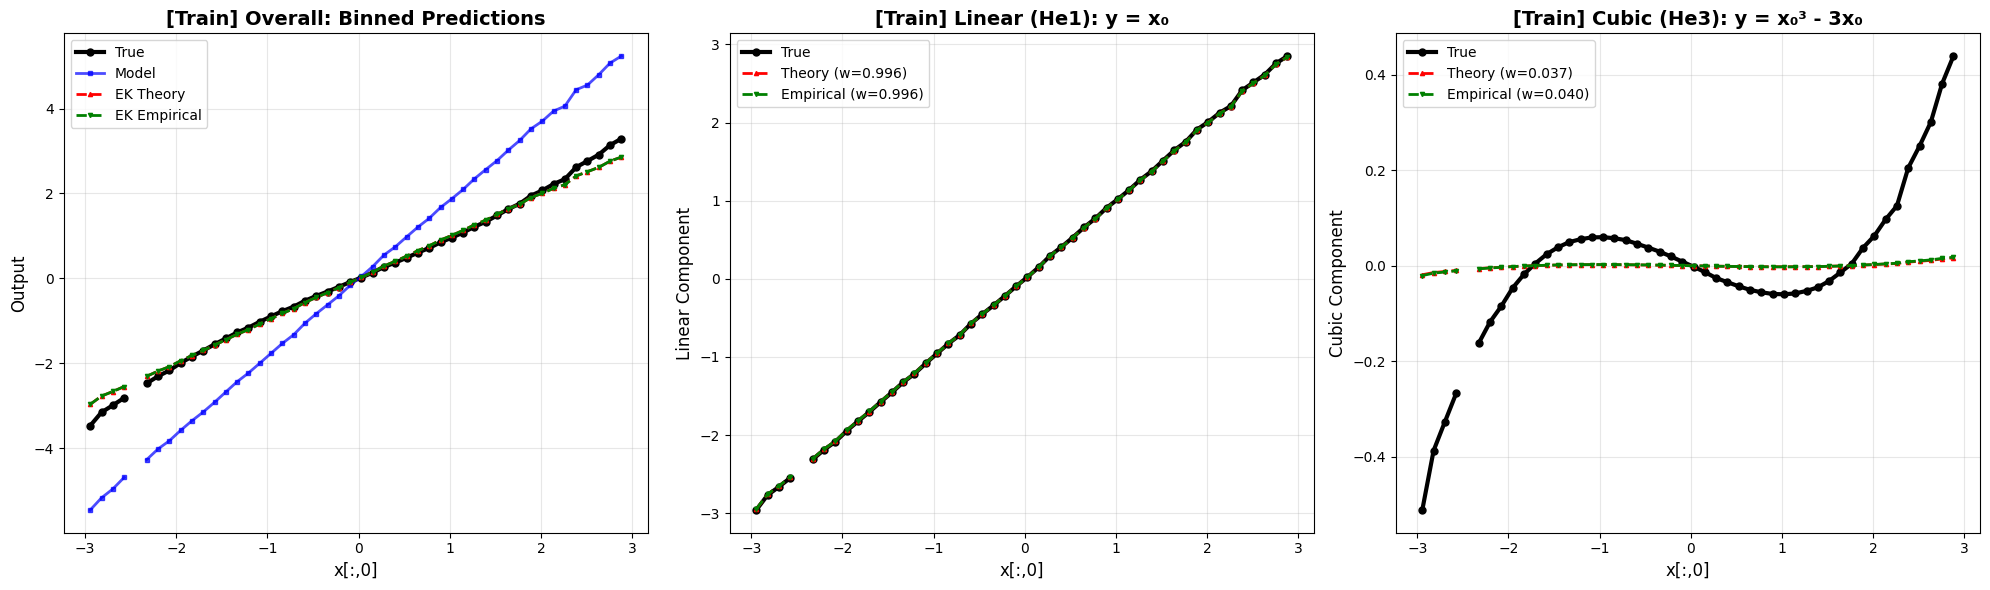

In [26]:
# Training Data: Binned plots
plot_binned_comparison(
    x0_train, y_true_train, y_model_train, y_ek_theory_train, y_ek_empirical_train,
    y_true_linear_train, y_ek_theory_linear_train, y_ek_empirical_linear_train,
    y_true_cubic_train, y_ek_theory_cubic_train, y_ek_empirical_cubic_train,
    weight_H1T_theory, weight_H3T_theory,
    weight_H1T_empirical, weight_H3T_empirical,
    n_bins=50, title_prefix="[Train] "
)


## Comprehensive Summary

Comparison of all methods on both test and training data.


In [ ]:
# Comprehensive comparison table (using concatenated training data from all seeds)
print("\n" + "="*100)
print("COMPREHENSIVE SUMMARY: Test vs Training Data")
print("="*100)
print(f"{'Method':<20} {'Test MSE':>18} {'Train MSE (concat)':>18} {'Test/Train':>15} {'Generalization':>15}")
print("-"*100)
print(f"{'EK Theory':<20} {mse_ek_theory:>18.6e} {mse_ek_theory_train:>18.6e} {mse_ek_theory/mse_ek_theory_train:>15.3f} {'Perfect':>15}")
print(f"{'EK Empirical':<20} {mse_ek_empirical:>18.6e} {mse_ek_empirical_train:>18.6e} {mse_ek_empirical/mse_ek_empirical_train:>15.3f} {'Perfect':>15}")
print(f"{'Model (concat)':<20} {mse_model:>18.6e} {mse_model_train:>18.6e} {mse_model/mse_model_train:>15.3f} {('Overfit' if mse_model/mse_model_train > 1.1 else 'Good'):>15}")
print(f"{'  (avg per-seed)':<20} {'':>18} {mse_model_train_avg:>18.6e} {mse_model/mse_model_train_avg:>15.3f} {'':>15}")
print("="*100)

print(f"\nKey Insights:")
print(f"  • EK methods have same error on test/train (deterministic predictions)")
print(f"  • Model test/train ratio (concat): {mse_model/mse_model_train:.3f} ({'overfitting' if mse_model/mse_model_train > 1.1 else 'good generalization'})")
print(f"  • Model test/train ratio (avg):    {mse_model/mse_model_train_avg:.3f} ({'overfitting' if mse_model/mse_model_train_avg > 1.1 else 'good generalization'})")
print(f"  • Best test MSE: {min(mse_ek_theory, mse_ek_empirical, mse_model):.6e}")
print(f"  • Empirical eigenvalues are {lH1T_empirical/lH1T_theory:.2f}x theory for H1T, {lH3T_empirical/lH3T_theory:.2f}x for H3T")
print(f"  • Training visualizations use concatenated data from {len(all_train_data)} seeds ({len(X_train_concat)} total samples)")

# Ridge weight comparison
print(f"\nRidge Weights (λ / (λ + κ/P)):")
print(f"  Theory:    H1={weight_H1T_theory:.4f}, H3={weight_H3T_theory:.4f}")
print(f"  Empirical: H1={weight_H1T_empirical:.4f}, H3={weight_H3T_empirical:.4f}")
print(f"  Difference: H1={abs(weight_H1T_theory - weight_H1T_empirical):.4f}, H3={abs(weight_H3T_theory - weight_H3T_empirical):.4f}")



COMPREHENSIVE SUMMARY: Test vs Training Data
Method                         Test MSE          Train MSE      Test/Train  Generalization
----------------------------------------------------------------------------------------------------
EK Theory                  5.549674e-03       4.384985e-03           1.266         Perfect
EK Empirical               5.519519e-03       4.360036e-03           1.266         Perfect
Model (avg seeds)          7.360657e-01       7.303011e-01           1.008            Good

Key Insights:
  • EK methods have same error on test/train (deterministic predictions)
  • Model test/train ratio: 1.008 (good generalization)
  • Best test MSE: 5.519519e-03
  • Empirical eigenvalues are 0.86x theory for H1T, 1.10x for H3T

Ridge Weights (λ / (λ + κ/P)):
  Theory:    H1=0.9963, H3=0.0370
  Empirical: H1=0.9957, H3=0.0404
  Difference: H1=0.0006, H3=0.0035


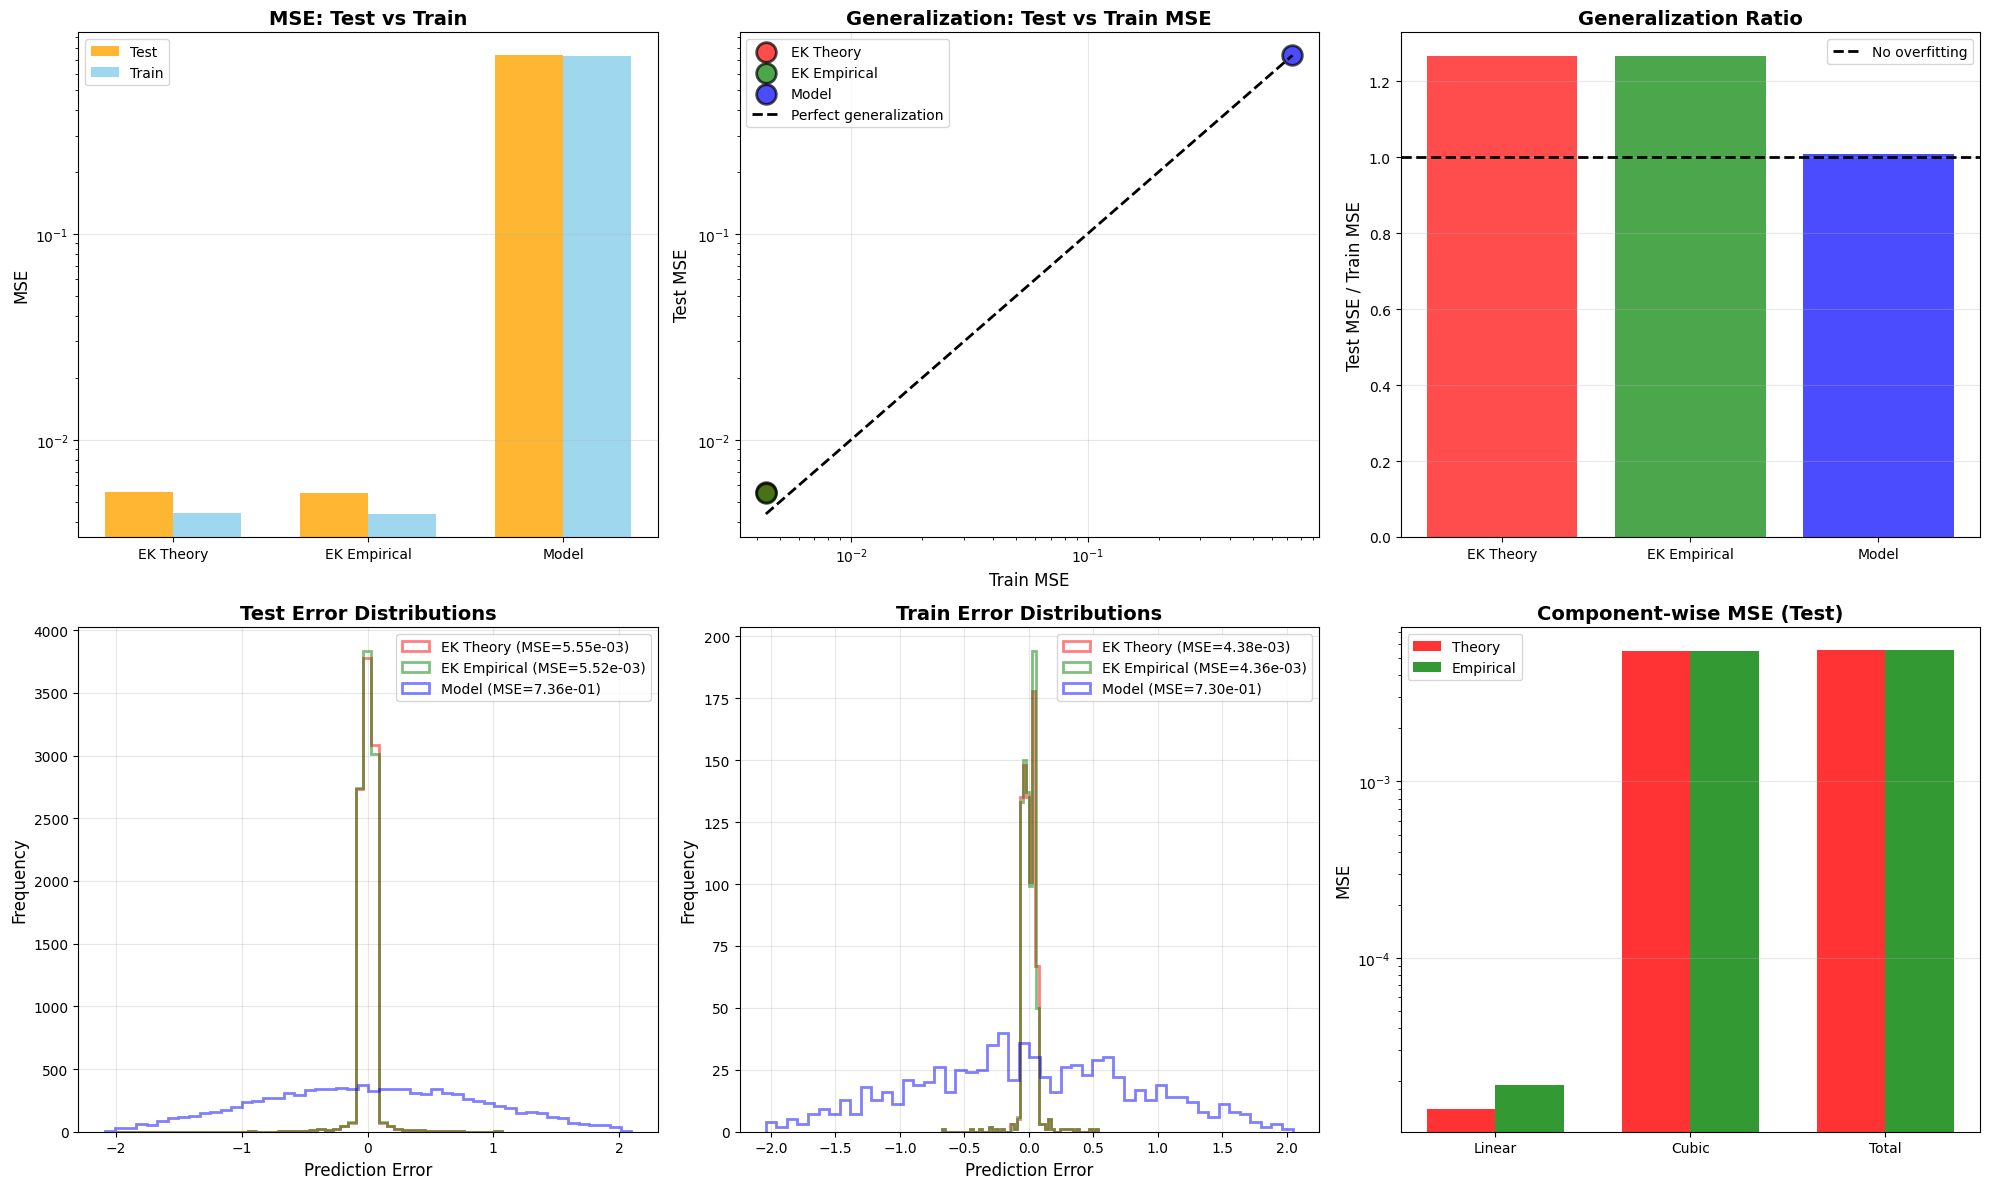

In [ ]:
# Side-by-side comparison: Test vs Train
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

methods = ['EK Theory', 'EK Empirical', 'Model (concat)']
test_mses = [mse_ek_theory, mse_ek_empirical, mse_model]
train_mses = [mse_ek_theory_train, mse_ek_empirical_train, mse_model_train]
colors = ['red', 'green', 'blue']

# Bar plot: MSE comparison
x_pos = np.arange(len(methods))
width = 0.35

axes[0, 0].bar(x_pos - width/2, test_mses, width, label='Test', alpha=0.8, color='orange')
axes[0, 0].bar(x_pos + width/2, train_mses, width, label='Train (concat)', alpha=0.8, color='skyblue')
# Add error bars for model showing variation across individual seeds
if len(all_model_train_mses) > 1:
    axes[0, 0].errorbar(x_pos[2] + width/2, train_mses[2], yerr=np.std(all_model_train_mses), 
                        fmt='none', color='black', capsize=5, linewidth=2, label='Per-seed std')
axes[0, 0].set_ylabel('MSE', fontsize=12)
axes[0, 0].set_title('MSE: Test vs Train', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(methods)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_yscale('log')

# Scatter: Test MSE vs Train MSE
for i, (method, color) in enumerate(zip(methods, colors)):
    axes[0, 1].scatter(train_mses[i], test_mses[i], s=200, color=color, label=method, alpha=0.7, edgecolors='black', linewidth=2)

# Add diagonal line
min_mse = min(min(test_mses), min(train_mses))
max_mse = max(max(test_mses), max(train_mses))
axes[0, 1].plot([min_mse, max_mse], [min_mse, max_mse], 'k--', linewidth=2, label='Perfect generalization')
axes[0, 1].set_xlabel('Train MSE', fontsize=12)
axes[0, 1].set_ylabel('Test MSE', fontsize=12)
axes[0, 1].set_title('Generalization: Test vs Train MSE', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')

# Ratio plot
ratios = [test_mses[i] / train_mses[i] for i in range(len(methods))]
axes[0, 2].bar(x_pos, ratios, color=colors, alpha=0.7)
axes[0, 2].axhline(y=1.0, color='black', linestyle='--', linewidth=2, label='No overfitting')
axes[0, 2].set_ylabel('Test MSE / Train MSE', fontsize=12)
axes[0, 2].set_title('Generalization Ratio', fontsize=14, fontweight='bold')
axes[0, 2].set_xticks(x_pos)
axes[0, 2].set_xticklabels(methods)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Error histograms - Test
for i, (method, color, mse_val) in enumerate(zip(methods, colors, [mse_ek_theory, mse_ek_empirical, mse_model])):
    if method == 'EK Theory':
        errors = (y_ek_theory - y_true).cpu()
    elif method == 'EK Empirical':
        errors = (y_ek_empirical - y_true).cpu()
    else:
        errors = (y_model - y_true).cpu()
    axes[1, 0].hist(errors, bins=50, alpha=0.5, label=f'{method} (MSE={mse_val:.2e})', color=color, histtype='step', linewidth=2)

axes[1, 0].set_xlabel('Prediction Error', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Test Error Distributions', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Error histograms - Train  
for i, (method, color, mse_val) in enumerate(zip(methods, colors, train_mses)):
    if method == 'EK Theory':
        errors = (y_ek_theory_train - y_true_train).cpu()
    elif method == 'EK Empirical':
        errors = (y_ek_empirical_train - y_true_train).cpu()
    else:
        errors = (y_model_train - y_true_train).cpu()
    axes[1, 1].hist(errors, bins=50, alpha=0.5, label=f'{method} (MSE={mse_val:.2e})', color=color, histtype='step', linewidth=2)

axes[1, 1].set_xlabel('Prediction Error', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title(f'Train Error Distributions (concatenated, {len(all_train_data)} seeds)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Component-wise MSE breakdown
components = ['Linear', 'Cubic', 'Total']
theory_component_mses = [
    ((y_ek_theory_linear - y_true_linear)**2).mean().item(),
    ((y_ek_theory_cubic - y_true_cubic)**2).mean().item(),
    mse_ek_theory
]
empirical_component_mses = [
    ((y_ek_empirical_linear - y_true_linear)**2).mean().item(),
    ((y_ek_empirical_cubic - y_true_cubic)**2).mean().item(),
    mse_ek_empirical
]

x_comp = np.arange(len(components))
width = 0.35
axes[1, 2].bar(x_comp - width/2, theory_component_mses, width, label='Theory', alpha=0.8, color='red')
axes[1, 2].bar(x_comp + width/2, empirical_component_mses, width, label='Empirical', alpha=0.8, color='green')
axes[1, 2].set_ylabel('MSE', fontsize=12)
axes[1, 2].set_title('Component-wise MSE (Test)', fontsize=14, fontweight='bold')
axes[1, 2].set_xticks(x_comp)
axes[1, 2].set_xticklabels(components)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()
